In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import to_date, hour
from pyspark.sql.functions import unix_timestamp, col
from pyspark.sql.functions import col, when
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import explode, sequence, col, lit, count, sum as _sum, date_format, hour
from pyspark.sql.functions import col, count, sum as _sum, date_format

from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import when, dayofweek

# functions
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, sum as _sum

# To csv

In [2]:
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/09/19 23:47:41 WARN Utils: Your hostname, KCT-DESKTOP resolves to a loopback address: 127.0.1.1; using 172.30.125.126 instead (on interface eth0)
24/09/19 23:47:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/19 23:47:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark.sql import DataFrame

# A function that describes dataset shape
def get_dataframe_shape(df: DataFrame) -> tuple:
    # Number of rows
    num_rows = df.count()

    # Number of columns
    num_columns = len(df.columns)

    # Return the shape as a tuple
    return (num_rows, num_columns)

In [5]:
raw_domain_df = spark.read.parquet("data/raw/domain_data.parquet")
domain_df = raw_domain_df
domain_df.show(5)
get_dataframe_shape(domain_df)

+---------+----------+-------------------+---------------+-----------+--------------------+------------+-------------+-------+--------+-----+----+-----------------+------------+----------+--------+--------------+------------------+--------------------+-------------+--------------------+--------------+-----+--------------------+--------------------+---------------+-----------------+----------------------+--------+------------------+-----------+---------+-------------+-------------------+
|agency_id|listing_id|limited_agency_mode|promotion_level|photo_count|       property_type|num_bedrooms|num_bathrooms|parking|is_rural|price|bond|energy_eff_rating|nbn_download|nbn_upload|nbn_tech|nbn_speed_tier|nbn_service_status|         unit_number|street_number|             address|        suburb|state|        listing_date| actual_listing_date|num_days_listed|inspections_count|last_modification_date|postcode|          latitude|  longitude|has_photo|has_floorplan|num_visible_schools|
+---------+-----

(16007, 34)

In [10]:
import pandas as pd
import pyarrow.parquet as pq

# Read the parquet file
parquet_file = pq.read_table('data/raw/domain_data.parquet')

# Convert the parquet file to CSV
csv_file_path = 'data/curated/domain_data.csv'
parquet_file.to_pandas().to_csv(csv_file_path, index=False)


# Pre-process

In [4]:
import pandas as pd

# Load CSV
file_path = 'data/curated/domain_data.csv'
domain_data = pd.read_csv(file_path)
domain_data.head()

,agency_id,listing_id,limited_agency_mode,promotion_level,photo_count,property_type,num_bedrooms,num_bathrooms,parking,is_rural,...,actual_listing_date,num_days_listed,inspections_count,last_modification_date,postcode,latitude,longitude,has_photo,has_floorplan,num_visible_schools
0,24974,10011763,False,ELITE,8,Apartment / Unit / Flat,1,1,1,False,...,2024-08-20T11:38:40.000,16,0,2024-08-20T11:38:40.08,3182.0,-37.860843,144.983995,True,True,3
1,24974,10026864,False,ELITE,13,Apartment / Unit / Flat,2,2,0,False,...,2024-08-19T12:28:26.000,17,0,2024-08-19T12:28:25.607,3000.0,-37.809309,144.959739,True,False,3
2,11740,10073916,False,STANDARD,8,Apartment / Unit / Flat,3,2,1,False,...,2024-08-28T11:34:02.000,8,0,2024-08-28T11:34:01.863,3033.0,-37.747722,144.866798,True,False,3
3,24974,10119117,False,ELITE,6,Apartment / Unit / Flat,1,1,1,False,...,2024-07-23T11:50:42.000,44,0,2024-08-12T12:13:52.853,3016.0,-37.859629,144.890406,True,False,3
4,21959,10128494,False,STANDARD,9,House,4,2,1,False,...,2024-08-09T10:12:55.000,27,0,2024-08-14T10:08:26.203,3167.0,-37.937272,145.093406,True,False,3


In [7]:
# First, drop the specified columns and perform data cleaning steps
columns_to_drop = [
    'nbn_service_status', 'nbn_download', 'nbn_speed_tier', 
    'nbn_tech', 'nbn_upload', 'bond', 'energy_eff_rating'
]

# Drop the unnecessary columns
domain_data_cleaned = domain_data.drop(columns=columns_to_drop, errors='ignore')

# Fill missing values in 'price' with median value if 'price' column exists
if 'price' in domain_data_cleaned.columns:
    domain_data_cleaned['price'].fillna(domain_data_cleaned['price'].median(), inplace=True)

# Fill missing values in 'postcode' with the mode (most frequent value)
domain_data_cleaned['postcode'].fillna(domain_data_cleaned['postcode'].mode()[0], inplace=True)

# Drop rows with missing 'street_number', if the column exists
if 'street_number' in domain_data_cleaned.columns:
    domain_data_cleaned.dropna(subset=['street_number'], inplace=True)

# Convert relevant columns to proper data types
domain_data_cleaned['actual_listing_date'] = pd.to_datetime(domain_data_cleaned['actual_listing_date'], errors='coerce', format='ISO8601')
domain_data_cleaned['last_modification_date'] = pd.to_datetime(domain_data_cleaned['last_modification_date'], errors='coerce', format='ISO8601')

# Convert boolean-like columns to bool type
domain_data_cleaned['limited_agency_mode'] = domain_data_cleaned['limited_agency_mode'].astype(bool)
domain_data_cleaned['is_rural'] = domain_data_cleaned['is_rural'].astype(bool)
domain_data_cleaned['has_photo'] = domain_data_cleaned['has_photo'].astype(bool)
domain_data_cleaned['has_floorplan'] = domain_data_cleaned['has_floorplan'].astype(bool)

# Check the cleaned dataset info
domain_data_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 15835 entries, 0 to 16006
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   agency_id               15835 non-null  int64         
 1   listing_id              15835 non-null  int64         
 2   limited_agency_mode     15835 non-null  bool          
 3   promotion_level         15835 non-null  object        
 4   photo_count             15835 non-null  int64         
 5   property_type           15835 non-null  object        
 6   num_bedrooms            15835 non-null  int64         
 7   num_bathrooms           15835 non-null  int64         
 8   parking                 15835 non-null  int64         
 9   is_rural                15835 non-null  bool          
 10  price                   15835 non-null  float64       
 11  unit_number             15835 non-null  object        
 12  street_number           15835 non-null  object     

In [8]:
domain_data_cleaned

,agency_id,listing_id,limited_agency_mode,promotion_level,photo_count,property_type,num_bedrooms,num_bathrooms,parking,is_rural,...,actual_listing_date,num_days_listed,inspections_count,last_modification_date,postcode,latitude,longitude,has_photo,has_floorplan,num_visible_schools
0,24974,10011763,False,ELITE,8,Apartment / Unit / Flat,1,1,1,False,...,2024-08-20 11:38:40,16,0,2024-08-20 11:38:40.080,3182.0,-37.860843,144.983995,True,True,3
1,24974,10026864,False,ELITE,13,Apartment / Unit / Flat,2,2,0,False,...,2024-08-19 12:28:26,17,0,2024-08-19 12:28:25.607,3000.0,-37.809309,144.959739,True,False,3
2,11740,10073916,False,STANDARD,8,Apartment / Unit / Flat,3,2,1,False,...,2024-08-28 11:34:02,8,0,2024-08-28 11:34:01.863,3033.0,-37.747722,144.866798,True,False,3
3,24974,10119117,False,ELITE,6,Apartment / Unit / Flat,1,1,1,False,...,2024-07-23 11:50:42,44,0,2024-08-12 12:13:52.853,3016.0,-37.859629,144.890406,True,False,3
4,21959,10128494,False,STANDARD,9,House,4,2,1,False,...,2024-08-09 10:12:55,27,0,2024-08-14 10:08:26.203,3167.0,-37.937272,145.093406,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16002,24974,9940435,False,ELITE,6,House,3,2,2,False,...,2024-08-19 11:41:05,17,0,2024-08-19 11:41:04.730,3338.0,-37.717389,144.597336,True,False,3
16003,24974,9945996,False,ELITE,7,Apartment / Unit / Flat,2,1,1,False,...,2024-08-27 12:00:54,9,0,2024-08-27 12:00:53.523,3144.0,-37.870108,145.035458,True,True,3
16004,20612,9948218,False,STANDARD,15,House,4,2,2,False,...,2024-08-28 22:47:22,7,0,2024-08-28 22:48:26.907,3029.0,-37.834144,144.684018,True,False,3
16005,24974,9960759,False,ELITE,4,House,3,1,0,False,...,2024-08-21 14:57:16,15,0,2024-08-21 14:57:15.530,3181.0,-37.854055,145.004678,True,True,3


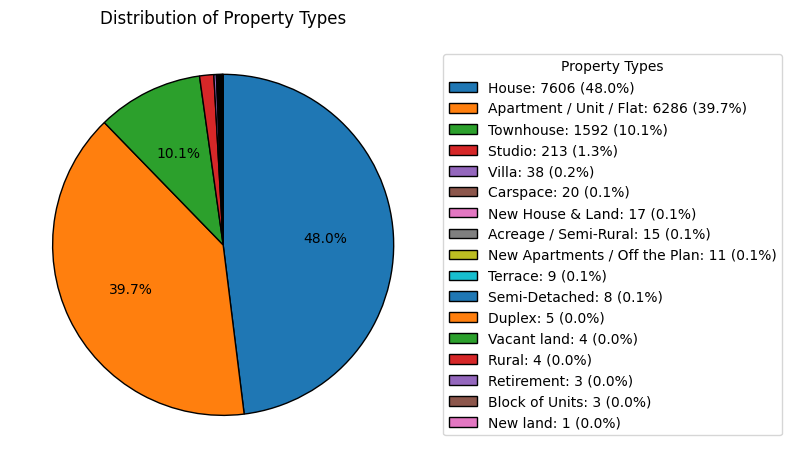

In [17]:
# Visualize the distribution of property types
property_type_counts = domain_data_cleaned['property_type'].value_counts()

# Function to label slices with percentages only if they are greater than 10%
def autopct_large_only(pct):
    return f'{pct:.1f}%' if pct >= 10 else ''

# Create the pie chart
plt.figure(figsize=(8, 8))
wedges, texts, autotexts = plt.pie(
    property_type_counts,
    autopct=autopct_large_only,
    startangle=90,
    counterclock=False,
    wedgeprops={'linewidth': 1.0, 'edgecolor': 'black'}
)

# Create a legend to show the property type and percentage for all categories
plt.legend(
    wedges,
    [f'{label}: {count} ({pct:.1f}%)' for label, count, pct in zip(property_type_counts.index, property_type_counts, 100 * property_type_counts / property_type_counts.sum())],
    title="Property Types",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

plt.title('Distribution of Property Types')
plt.tight_layout()
plt.show()


In [9]:
# First, let's check the actual available data to aggregate by suburb.
# We'll aggregate by suburb and use the 'price' and 'listing_date' fields (if available).

# Extracting 'listing_date' column and converting it to datetime
domain_data_cleaned['listing_date'] = pd.to_datetime(domain_data_cleaned['listing_date'], errors='coerce')

# Group by 'suburb' and calculate the monthly average price and total listings
suburb_aggregation = domain_data_cleaned.groupby([pd.Grouper(key='listing_date', freq='M'), 'suburb']).agg(
    avg_price=('price', 'mean'),
    total_listings=('listing_id', 'count')
).reset_index()

ModuleNotFoundError: No module named 'ace_tools'

/home/kevin/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


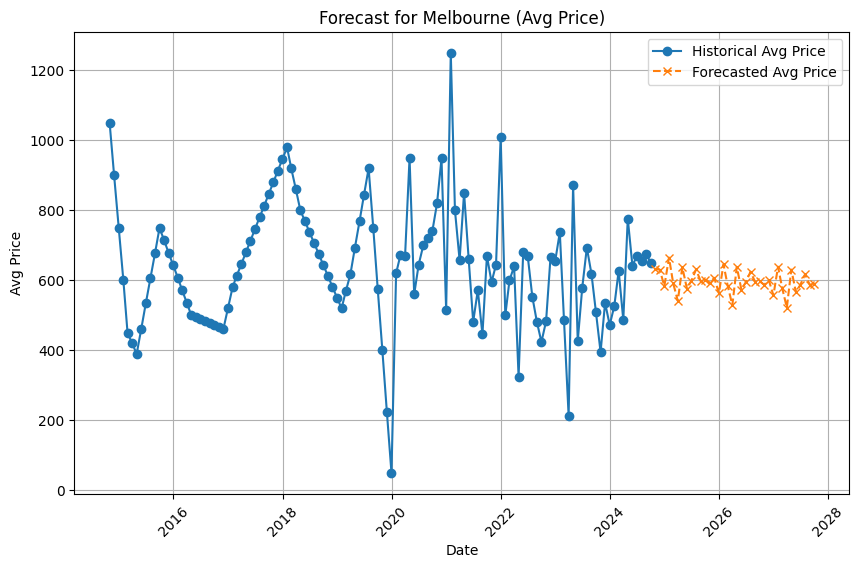

/home/kevin/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


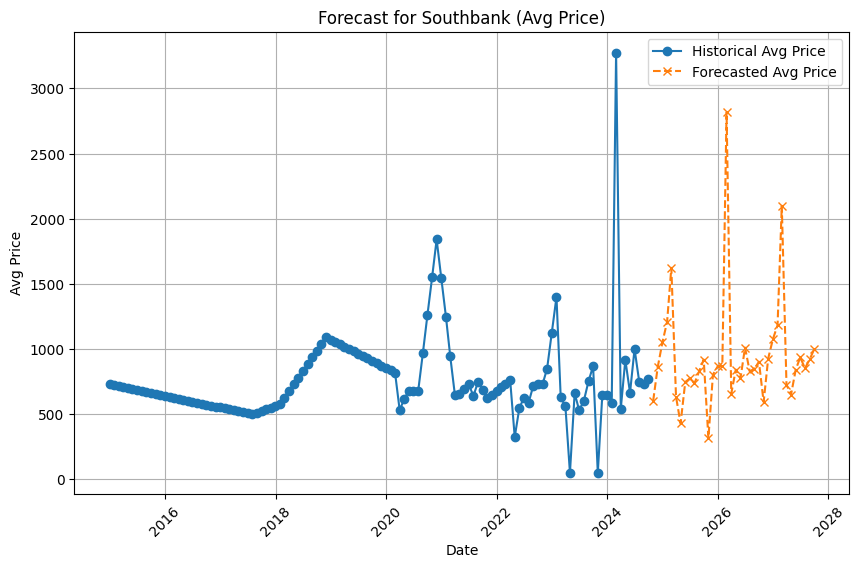

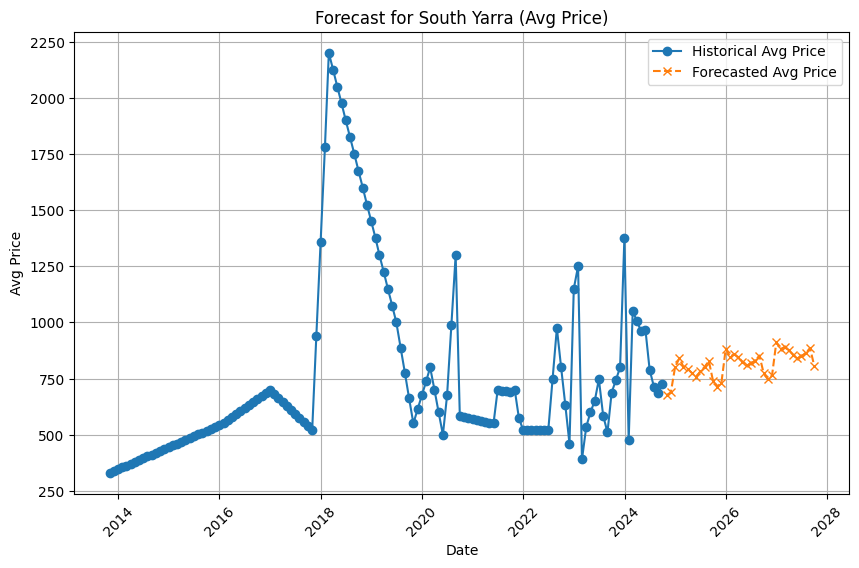

/home/kevin/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/kevin/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


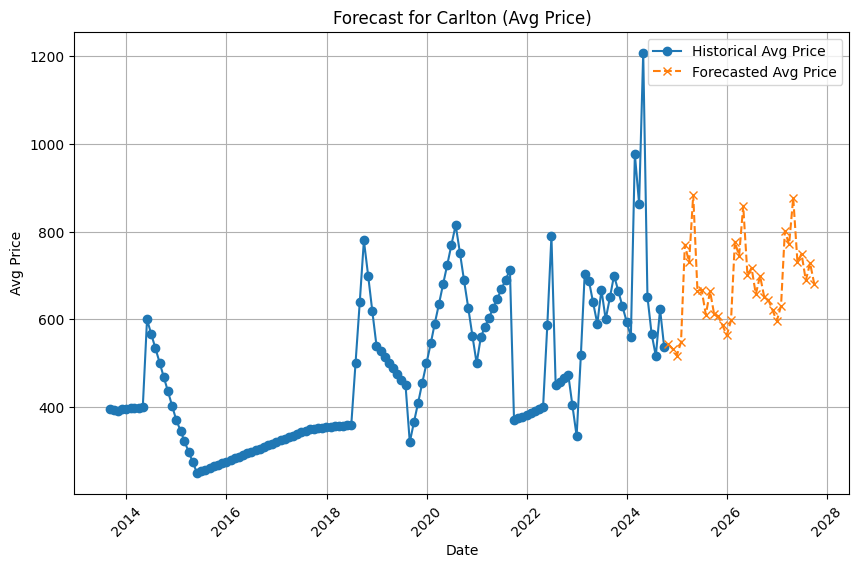

/home/kevin/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


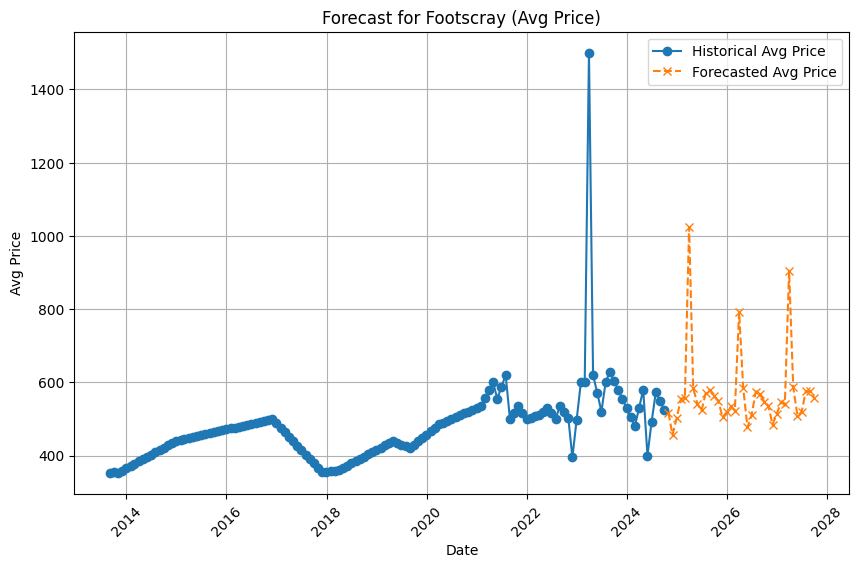

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Re-run the entire process to handle the forecasting issue
# Filter the data for a few example suburbs to make the visualization easier
suburbs_to_forecast = suburb_aggregation['suburb'].value_counts().index[:5]  # Top 5 suburbs with most listings

# Create a dictionary to store results
forecast_results = {}

# Forecast for each selected suburb
forecast_period = 36  # 3 years into the future (12 months * 3 years)
for suburb in suburbs_to_forecast:
    # Filter data for this suburb
    suburb_data = suburb_aggregation[suburb_aggregation['suburb'] == suburb].set_index('listing_date').asfreq('M')
    
    # Filling missing values with interpolation (since some months might have no data)
    suburb_data['avg_price'].interpolate(method='linear', inplace=True)
    
    # Fit an ARIMA model (SARIMA is better for seasonality, but we will keep it simple for now)
    model = SARIMAX(suburb_data['avg_price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    
    # Make prediction for the next 3 years
    forecast = model_fit.get_forecast(steps=forecast_period)
    forecast_index = pd.date_range(suburb_data.index[-1], periods=forecast_period + 1, freq='M')[1:]  # Forecast for future
    forecast_prices = forecast.predicted_mean
    
    # Store the forecast results
    forecast_results[suburb] = (forecast_index, forecast_prices)

    # Plot the original data and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(suburb_data.index, suburb_data['avg_price'], label='Historical Avg Price', marker='o')
    plt.plot(forecast_index, forecast_prices, label='Forecasted Avg Price', linestyle='--', marker='x')
    plt.title(f"Forecast for {suburb} (Avg Price)")
    plt.xlabel('Date')
    plt.ylabel('Avg Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()


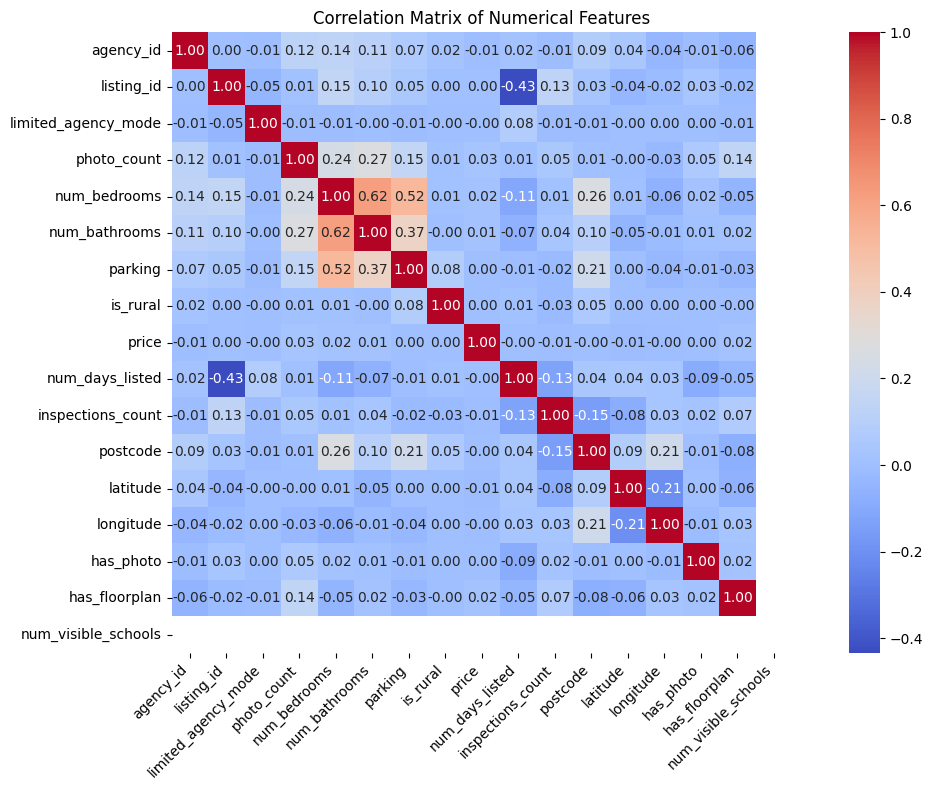

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the correlation matrix for numerical features
numerical_columns = domain_data_cleaned.select_dtypes(include=['float64', 'int64', 'bool']).columns
correlation_matrix = domain_data_cleaned[numerical_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a heatmap with the correlation matrix, displaying the values in the boxes
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, square=True)

# Set the title and display the plot
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [17]:
# Extract correlations related to 'price'
price_correlations = correlation_matrix['price'].dropna()

# Sort correlations by their absolute values in descending order to find the strongest correlations
price_correlations_sorted = price_correlations.abs().sort_values(ascending=False)

# Display the top features most correlated with 'price'
price_correlations_sorted


price                  1.000000
photo_count            0.028670
has_floorplan          0.016401
num_bedrooms           0.016129
num_bathrooms          0.014558
latitude               0.010903
inspections_count      0.005666
agency_id              0.005449
listing_id             0.004284
longitude              0.003705
postcode               0.001645
num_days_listed        0.001618
parking                0.000836
has_photo              0.000602
limited_agency_mode    0.000291
is_rural               0.000038
Name: price, dtype: float64

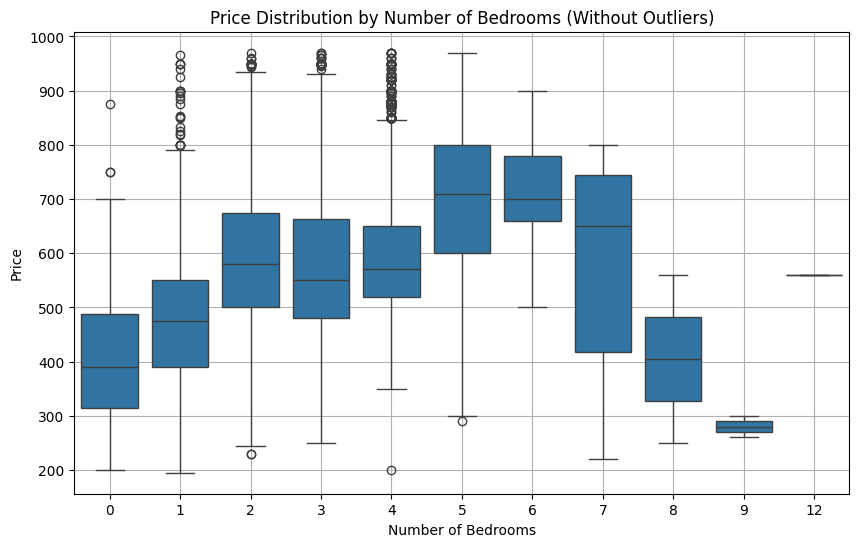

,num_bedrooms,price
0,0,412.018182
1,1,470.572680
2,2,588.317325
3,3,582.398603
4,4,604.002704
5,5,710.521127
6,6,711.190476
7,7,570.714286
8,8,405.000000
9,9,280.000000


In [18]:
# Calculate the Interquartile Range (IQR) for the 'price' column
Q1 = domain_data_cleaned['price'].quantile(0.25)
Q3 = domain_data_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset to remove outliers
domain_data_no_outliers = domain_data_cleaned[(domain_data_cleaned['price'] >= lower_bound) & 
                                              (domain_data_cleaned['price'] <= upper_bound)]

# Plotting the updated boxplot to show the distribution of price for different bedroom counts without outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='num_bedrooms', y='price', data=domain_data_no_outliers)
plt.title('Price Distribution by Number of Bedrooms (Without Outliers)')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Recalculate the average price by number of bedrooms without outliers
avg_price_by_bedrooms_no_outliers = domain_data_no_outliers.groupby('num_bedrooms')['price'].mean().reset_index()

# Display the new calculated averages
avg_price_by_bedrooms_no_outliers


# School (Aggregate Data)

In [22]:

import pandas as pd

# Load the CSV file to inspect the contents
file_path = "data/raw/dv346-schoollocations2023.csv"
school_data = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the first few rows of the dataset to understand its structure
school_data.head()


,Education_Sector,Entity_Type,School_No,School_Name,School_Type,School_Status,Address_Line_1,Address_Line_2,Address_Town,Address_State,...,Postal_Address_Line_1,Postal_Address_Line_2,Postal_Town,Postal_State,Postal_Postcode,Full_Phone_No,LGA_ID,LGA_Name,X,Y
0,Government,1,1,Alberton Primary School,Primary,O,21 Thomson Street,NaN,Alberton,VIC,...,21 Thomson Street,NaN,ALBERTON,VIC,3971,03 5183 2412,681,Wellington (S),146.66660,-38.61771
1,Government,1,3,Allansford and District Primary School,Primary,O,Frank Street,NaN,Allansford,VIC,...,Frank Street,NaN,ALLANSFORD,VIC,3277,03 5565 1382,673,Warrnambool (C),142.59039,-38.38628
2,Government,1,4,Avoca Primary School,Primary,O,118 Barnett Street,NaN,Avoca,VIC,...,P O Box 12,NaN,AVOCA,VIC,3467,03 5465 3176,599,Pyrenees (S),143.47565,-37.08450
3,Government,1,8,Avenel Primary School,Primary,O,40 Anderson Street,NaN,Avenel,VIC,...,40 Anderson Street,NaN,AVENEL,VIC,3664,03 5796 2264,643,Strathbogie (S),145.23472,-36.90137
4,Government,1,12,Warrandyte Primary School,Primary,O,5-11 Forbes Street,NaN,Warrandyte,VIC,...,5-11 Forbes Street,NaN,WARRANDYTE,VIC,3113,03 9844 3537,421,Manningham (C),145.21398,-37.74268


   Number_of_Schools  Number_of_Suburbs
0                  1                277
1                  2                 30
2                  3                  6


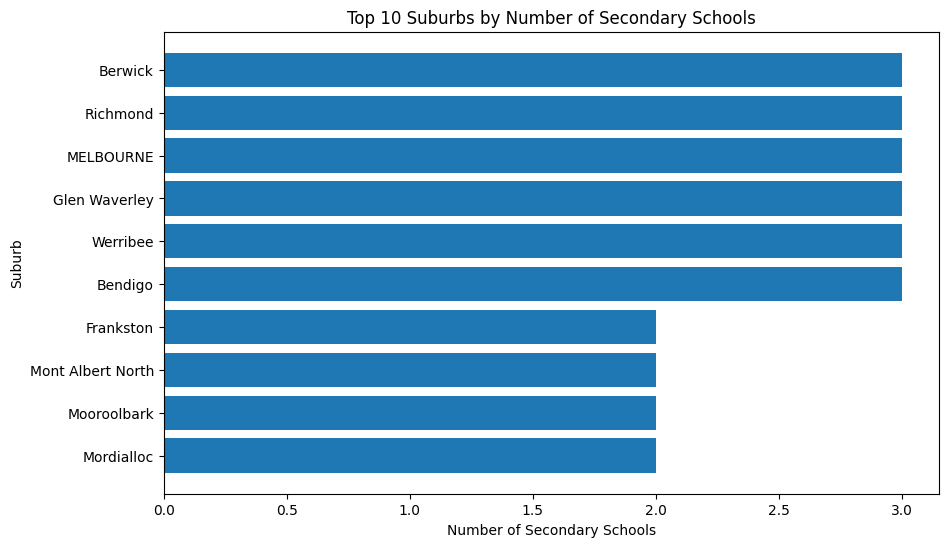

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for Secondary Schools
secondary_schools = school_data[school_data['School_Type'] == 'Secondary']

# Group by Address_Town (suburb) and count the number of secondary schools in each suburb
secondary_school_counts = secondary_schools.groupby('Address_Town').size().reset_index(name='Secondary_School_Count')

# Sort by the count of secondary schools
secondary_school_counts_sorted = secondary_school_counts.sort_values(by='Secondary_School_Count', ascending=False)

# Display the counts for each suburb with 1, 2, 3, etc. secondary schools
suburb_school_counts_distribution = secondary_school_counts_sorted['Secondary_School_Count'].value_counts().reset_index()
suburb_school_counts_distribution.columns = ['Number_of_Schools', 'Number_of_Suburbs']

# Sort by the number of schools for better readability
suburb_school_counts_distribution_sorted = suburb_school_counts_distribution.sort_values(by='Number_of_Schools')

# Print the distribution of secondary schools in suburbs
print(suburb_school_counts_distribution_sorted)

# Visualize the top 10 suburbs with the highest number of secondary schools
top_secondary_school_counts = secondary_school_counts_sorted.head(10)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_secondary_school_counts['Address_Town'], top_secondary_school_counts['Secondary_School_Count'])
plt.xlabel('Number of Secondary Schools')
plt.ylabel('Suburb')
plt.title('Top 10 Suburbs by Number of Secondary Schools')
plt.gca().invert_yaxis()  # Invert y-axis to have the lar


In [25]:
secondary_school_counts_sorted

,Address_Town,Secondary_School_Count
33,Berwick,3
236,Richmond,3
169,MELBOURNE,3
121,Glen Waverley,3
301,Werribee,3
...,...,...
110,Flemington,1
109,Fitzroy North,1
108,Fawkner,1
107,FRANKSTON,1


In [26]:
domain_data_cleaned

,agency_id,listing_id,limited_agency_mode,promotion_level,photo_count,property_type,num_bedrooms,num_bathrooms,parking,is_rural,...,actual_listing_date,num_days_listed,inspections_count,last_modification_date,postcode,latitude,longitude,has_photo,has_floorplan,num_visible_schools
0,24974,10011763,False,ELITE,8,Apartment / Unit / Flat,1,1,1,False,...,2024-08-20 11:38:40,16,0,2024-08-20 11:38:40.080,3182.0,-37.860843,144.983995,True,True,3
1,24974,10026864,False,ELITE,13,Apartment / Unit / Flat,2,2,0,False,...,2024-08-19 12:28:26,17,0,2024-08-19 12:28:25.607,3000.0,-37.809309,144.959739,True,False,3
2,11740,10073916,False,STANDARD,8,Apartment / Unit / Flat,3,2,1,False,...,2024-08-28 11:34:02,8,0,2024-08-28 11:34:01.863,3033.0,-37.747722,144.866798,True,False,3
3,24974,10119117,False,ELITE,6,Apartment / Unit / Flat,1,1,1,False,...,2024-07-23 11:50:42,44,0,2024-08-12 12:13:52.853,3016.0,-37.859629,144.890406,True,False,3
4,21959,10128494,False,STANDARD,9,House,4,2,1,False,...,2024-08-09 10:12:55,27,0,2024-08-14 10:08:26.203,3167.0,-37.937272,145.093406,True,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16002,24974,9940435,False,ELITE,6,House,3,2,2,False,...,2024-08-19 11:41:05,17,0,2024-08-19 11:41:04.730,3338.0,-37.717389,144.597336,True,False,3
16003,24974,9945996,False,ELITE,7,Apartment / Unit / Flat,2,1,1,False,...,2024-08-27 12:00:54,9,0,2024-08-27 12:00:53.523,3144.0,-37.870108,145.035458,True,True,3
16004,20612,9948218,False,STANDARD,15,House,4,2,2,False,...,2024-08-28 22:47:22,7,0,2024-08-28 22:48:26.907,3029.0,-37.834144,144.684018,True,False,3
16005,24974,9960759,False,ELITE,4,House,3,1,0,False,...,2024-08-21 14:57:16,15,0,2024-08-21 14:57:15.530,3181.0,-37.854055,145.004678,True,True,3


In [29]:
# Aggregate data by 'postcode' (assuming this represents the suburb)
domain_data_cleaned['suburb'] = domain_data_cleaned['suburb'].astype(str).str.lower()

aggregated_data = domain_data_cleaned.groupby('suburb').agg({
    'num_days_listed': 'mean',  # Average number of days listed
    'inspections_count': 'sum',  # Total inspections count
    'num_visible_schools': 'mean',  # Average number of visible schools
    'longitude': 'mean',  # Average longitude for geographic center
    'latitude': 'mean',   # Average latitude for geographic center
}).reset_index()

# Rename columns for clarity
aggregated_data.columns = ['Suburb (Postcode)', 'Avg Days Listed', 'Total Inspections', 'Avg Visible Schools', 'Avg Longitude', 'Avg Latitude']

# Display the aggregated data
print(aggregated_data)


    Suburb (Postcode)  Avg Days Listed  Total Inspections  \
0          abbotsford        31.358209                 58   
1          aberfeldie        24.571429                  5   
2             aintree        20.478261                 17   
3        aireys inlet        39.500000                  0   
4        airport west        21.750000                 17   
..                ...              ...                ...   
784        yarraville        24.686567                 50   
785        yarrawonga        42.875000                  0   
786               yea       454.000000                  0   
787            yinnar        37.500000                  1   
788      yinnar south         8.000000                  0   

     Avg Visible Schools  Avg Longitude  Avg Latitude  
0                    3.0     145.004811    -37.807900  
1                    3.0     144.893926    -37.759341  
2                    3.0     144.670570    -37.721748  
3                    3.0     144.104420    

In [30]:
# Convert the 'Address_Town' column to lowercase
secondary_school_counts_sorted['Address_Town'] = secondary_school_counts_sorted['Address_Town'].str.lower()

# Display the updated DataFrame
print(secondary_school_counts_sorted)

      Address_Town  Secondary_School_Count
33         berwick                       3
236       richmond                       3
169      melbourne                       3
121  glen waverley                       3
301       werribee                       3
..             ...                     ...
110     flemington                       1
109  fitzroy north                       1
108        fawkner                       1
107      frankston                       1
312            yea                       1

[313 rows x 2 columns]


In [31]:
# Ensure both columns are lowercase for consistent matching
secondary_school_counts_sorted['Address_Town'] = secondary_school_counts_sorted['Address_Town'].str.lower()
aggregated_data['Suburb (Postcode)'] = aggregated_data['Suburb (Postcode)'].str.lower()

# Perform the merge based on the suburb column
merged_data = pd.merge(secondary_school_counts_sorted, aggregated_data, 
                       left_on='Address_Town', right_on='Suburb (Postcode)', 
                       how='inner')  # Use 'inner' join to only keep matching suburbs

# Display the merged DataFrame
print(merged_data)


      Address_Town  Secondary_School_Count Suburb (Postcode)  Avg Days Listed  \
0          berwick                       3           berwick        47.457831   
1         richmond                       3          richmond        27.146199   
2         richmond                       1          richmond        27.146199   
3        melbourne                       3         melbourne        84.282364   
4        melbourne                       1         melbourne        84.282364   
..             ...                     ...               ...              ...   
296      footscray                       1         footscray        91.082803   
297     flemington                       1        flemington        85.400000   
298  fitzroy north                       1     fitzroy north        33.388889   
299        fawkner                       1           fawkner        27.470588   
300            yea                       1               yea       454.000000   

     Total Inspections  Avg

In [32]:
# Ensure both columns are lowercase for consistent matching
secondary_school_counts_sorted['Address_Town'] = secondary_school_counts_sorted['Address_Town'].str.lower()
aggregated_data['Suburb (Postcode)'] = aggregated_data['Suburb (Postcode)'].str.lower()

# Perform the merge based on the suburb column
merged_data = pd.merge(secondary_school_counts_sorted, aggregated_data, 
                       left_on='Address_Town', right_on='Suburb (Postcode)', 
                       how='inner')  # Use 'inner' join to only keep matching suburbs

# Export the merged data to a CSV file
output_file_path = 'data/curated/merged_secondary_school_data.csv'
merged_data.to_csv(output_file_path, index=False)

# Provide the download link
output_file_path

'data/curated/merged_secondary_school_data.csv'

# School

In [33]:
import pandas as pd

# Load the CSV file to inspect its contents
file_path = 'data/curated/merged_secondary_school_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows and summary of the dataset
data

,Address_Town,Secondary_School_Count,Suburb (Postcode),Avg Days Listed,Total Inspections,Avg Visible Schools,Avg Longitude,Avg Latitude
0,berwick,3,berwick,47.457831,45,3.0,145.345833,-38.052388
1,richmond,3,richmond,27.146199,94,3.0,145.002605,-37.818746
2,richmond,1,richmond,27.146199,94,3.0,145.002605,-37.818746
3,melbourne,3,melbourne,84.282364,748,3.0,144.962043,-37.815448
4,melbourne,1,melbourne,84.282364,748,3.0,144.962043,-37.815448
...,...,...,...,...,...,...,...,...
296,footscray,1,footscray,91.082803,105,3.0,144.899552,-37.797856
297,flemington,1,flemington,85.400000,31,3.0,144.924037,-37.784841
298,fitzroy north,1,fitzroy north,33.388889,20,3.0,144.983337,-37.784387
299,fawkner,1,fawkner,27.470588,15,3.0,144.969440,-37.705955
